Система интеллектуального подбора кандидатов (оптимизированная версия)
Платформа Iconicompany

Создание файла с зависимостями...
Создан файл requirements.txt

[1/5] Инициализация системы подбора...
Загрузка модели nomic-ai/nomic-embed-text-v1.5...


<All keys matched successfully>


Файл skill_patterns.json не найден. Используем базовые паттерны.
Загрузка модели spaCy для извлечения навыков...
Не удалось загрузить spaCy: [E050] Can't find model 'ru_core_news_sm'. It doesn't seem to be a Python package or a valid path to a data directory.. Используем регулярные выражения.

[2/5] Загрузка данных...
Загружено резюме 1
Загружено резюме 10
Загружено резюме 11
Загружено резюме 13
Загружено резюме 14
Загружено резюме 15
Загружено резюме 16
Загружено резюме 17
Загружено резюме 18
Загружено резюме 19
Загружено резюме 2
Загружено резюме 20
Загружено резюме 21
Загружено резюме 22
Загружено резюме 23
Загружено резюме 24
Загружено резюме 25
Загружено резюме 26
Загружено резюме 27
Загружено резюме 28
Загружено резюме 29
Загружено резюме 3
Загружено резюме 30
Загружено резюме 31
Загружено резюме 32
Загружено резюме 33
Загружено резюме 34
Загружено резюме 35
Загружено резюме 36
Загружено резюме 37
Загружено резюме 38
Загружено резюме 39
Загружено резюме 4
Загружено резюме 40
Загр

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Построение FAISS индекса...
FAISS индекс построен: 5 векторов

Кодирование резюме...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]


[4/5] Оптимизированное ранжирование вакансий для резюме...
  Резюме 1: обработано за 0.080с, найдено 5 вакансий
  Резюме 2: обработано за 0.084с, найдено 5 вакансий
  Резюме 3: обработано за 0.066с, найдено 5 вакансий
  Резюме 4: обработано за 0.072с, найдено 5 вакансий
  Резюме 5: обработано за 0.113с, найдено 5 вакансий

Ранжирование завершено за 2.22 секунд
Среднее время на резюме: 0.074 секунд

[5/5] Оценка качества подбора...
  CV #1: NDCG@5=0.7250, GT=[37, 8, 207, 90, 499], Pred top 3=[207, 499, 90]
  CV #2: NDCG@5=0.7348, GT=[8, 37, 90, 207, 499], Pred top 3=[207, 37, 499]
  CV #3: NDCG@5=0.7949, GT=[8, 37, 90, 207, 499], Pred top 3=[207, 8, 499]
  CV #4: NDCG@5=0.7098, GT=[90, 8, 37, 207, 499], Pred top 3=[207, 37, 8]
  CV #5: NDCG@5=0.7289, GT=[8, 499, 207, 37, 90], Pred top 3=[207, 37, 90]
⚠ Резюме 31: нет ground truth

Результаты оценки
Средний NDCG@5: 0.7768
Оценено резюме: 29
Время обработки: 2.22 секунд

Детали NDCG по каждому резюме:
   CV #1: 0.7250
   CV #2: 0.7348
  

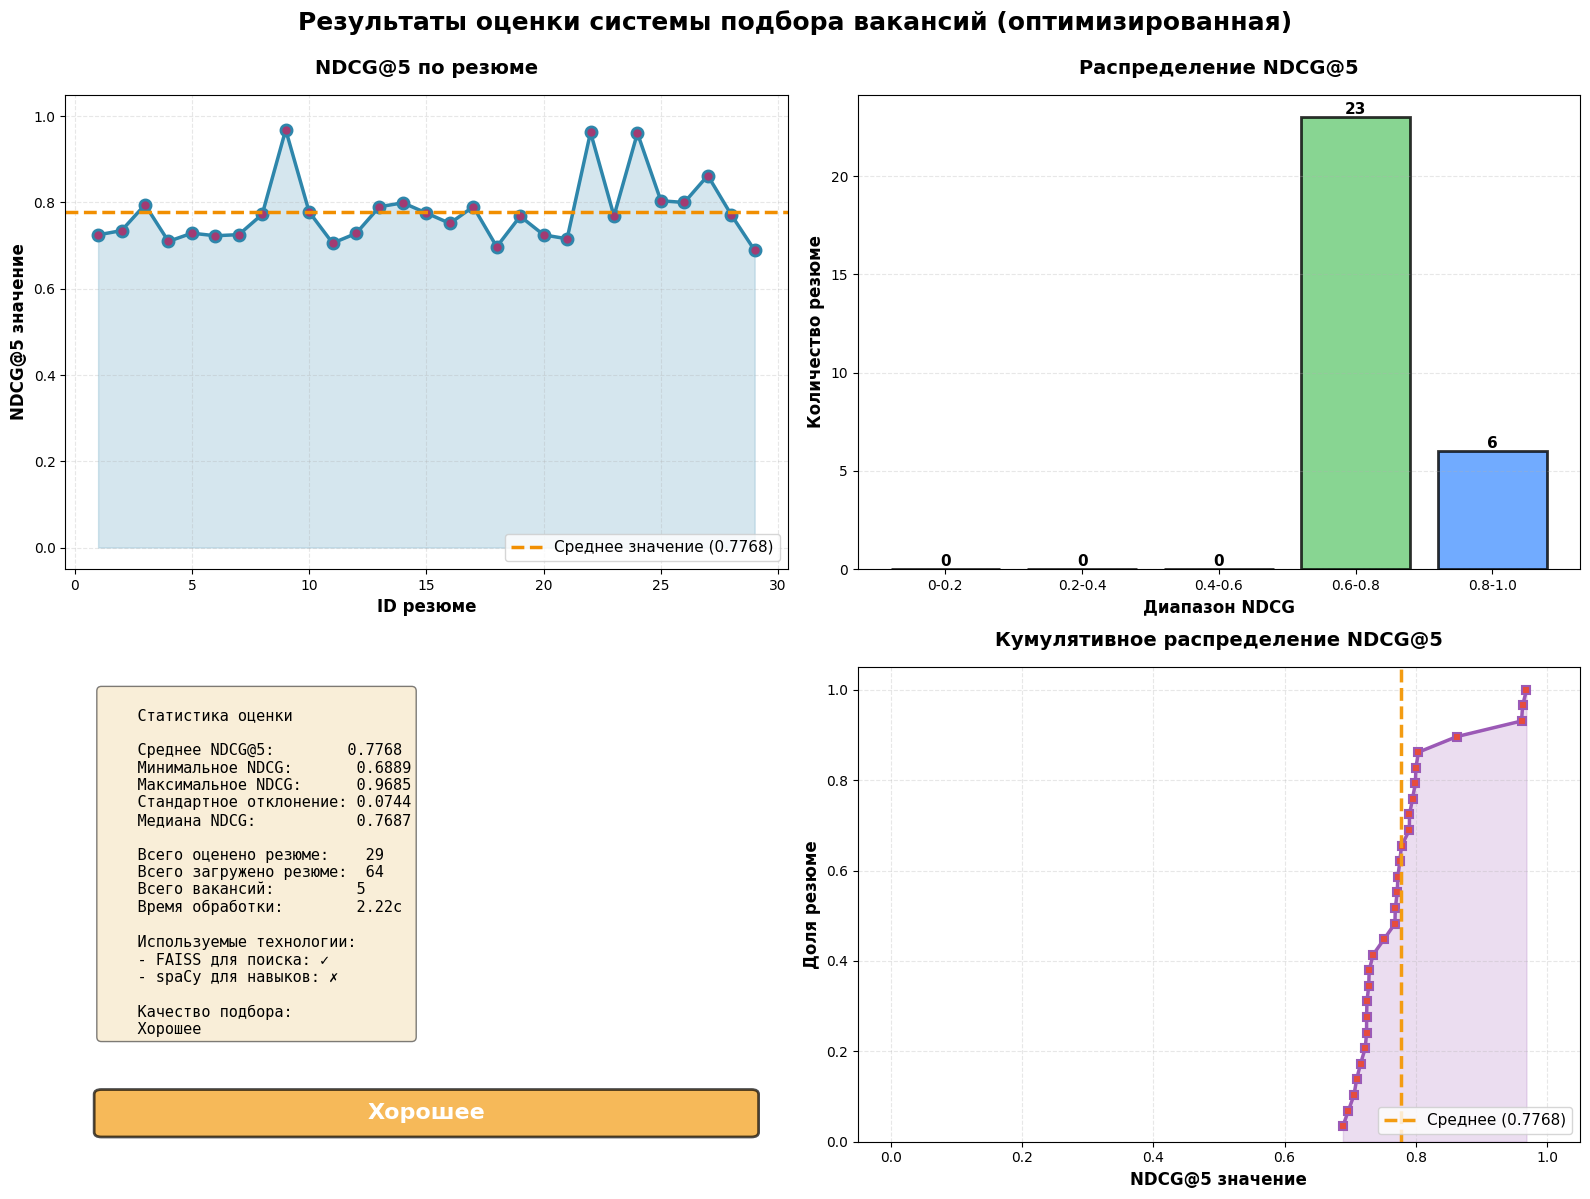


Обработка завершена успешно!


In [6]:
import os
import csv
import re
import json
from pathlib import Path
from typing import List, Tuple, Dict, Set, Optional
import numpy as np
from collections import defaultdict
import time

# Для векторного поиска
import faiss
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# Для улучшенного извлечения навыков
import spacy
from spacy.matcher import PhraseMatcher

class VacancyResumeMatcher:
    """
    Система для матчинга резюме с вакансиями
    Использует оптимизированный векторный поиск через FAISS и расширенное извлечение навыков
    """

    def __init__(self, model_name: str = "nomic-ai/nomic-embed-text-v1.5",
                 use_faiss: bool = True, use_spacy: bool = True):
        """
        Инициализация модели эмбеддингов и компонентов системы

        Args:
            model_name: название модели для эмбеддингов
            use_faiss: использовать ли FAISS для оптимизированного поиска
            use_spacy: использовать ли spaCy для улучшенного извлечения навыков
        """
        print(f"Загрузка модели {model_name}...")
        self.model = SentenceTransformer(model_name, trust_remote_code=True)
        self.scaler = MinMaxScaler()
        self.use_faiss = use_faiss
        self.use_spacy = use_spacy

        # Инициализация FAISS индекса
        self.faiss_index = None
        self.vacancy_ids_in_index = None

        # Инициализация spaCy для извлечения навыков
        self.nlp = None
        self.skill_matcher = None
        self.skill_patterns = self._load_skill_patterns()

        if use_spacy:
            try:
                print("Загрузка модели spaCy для извлечения навыков...")
                self.nlp = spacy.load("ru_core_news_sm")
                self._init_skill_matcher()
                print("Модель spaCy загружена")
            except Exception as e:
                print(f"Не удалось загрузить spaCy: {e}. Используем регулярные выражения.")
                self.use_spacy = False

    def _load_skill_patterns(self) -> Dict[str, List[str]]:
        """Загрузка паттернов навыков из файла или базового набора"""
        skill_patterns = {
            'programming': [
                'python', 'java', 'c++', 'c#', 'javascript', 'typescript', 'php', 'ruby',
                'go', 'rust', 'kotlin', 'swift', 'scala', 'r', 'matlab'
            ],
            'databases': [
                'sql', 'mysql', 'postgresql', 'oracle', 'mongodb', 'elasticsearch', 'redis',
                'cassandra', 'dynamodb', 'bigquery', 'snowflake', 'clickhouse'
            ],
            'frameworks': [
                'react', 'angular', 'vue', 'django', 'flask', 'spring', 'asp.net', 'express',
                'laravel', 'ruby on rails', 'fastapi', 'tensorflow', 'pytorch'
            ],
            'cloud': [
                'aws', 'azure', 'gcp', 'kubernetes', 'docker', 'jenkins', 'gitlab',
                'terraform', 'ansible', 'prometheus', 'grafana', 'helm'
            ],
            'tools': [
                'git', 'svn', 'jira', 'confluence', 'figma', 'tableau', 'power bi',
                'postman', 'swagger', 'apache kafka', 'rabbitmq'
            ],
            'methodologies': [
                'agile', 'scrum', 'kanban', 'devops', 'ci/cd', 'tdd', 'bdd',
                'microservices', 'rest', 'api', 'graphql', 'soap'
            ]
        }

        # Попытка загрузить из файла
        try:
            with open('skill_patterns.json', 'r', encoding='utf-8') as f:
                custom_patterns = json.load(f)
                skill_patterns.update(custom_patterns)
                print("✓ Загружены пользовательские паттерны навыков")
        except FileNotFoundError:
            print("Файл skill_patterns.json не найден. Используем базовые паттерны.")

        return skill_patterns

    def _init_skill_matcher(self):
        """Инициализация PhraseMatcher для поиска навыков"""
        if self.nlp and self.use_spacy:
            self.skill_matcher = PhraseMatcher(self.nlp.vocab, attr="LOWER")

            # Добавляем паттерны для всех навыков
            all_skills = []
            for category, skills in self.skill_patterns.items():
                all_skills.extend(skills)

            patterns = [self.nlp.make_doc(skill) for skill in all_skills]
            self.skill_matcher.add("SKILLS", patterns)

    def extract_text_from_docx(self, filepath: str) -> str:
        """
        Извлечение текста из DOCX файла
        """
        try:
            from docx import Document
            doc = Document(filepath)
            text = "\n".join([para.text for para in doc.paragraphs])
            return text
        except Exception as e:
            print(f"Ошибка при чтении {filepath}: {e}")
            return ""

    def load_resumes(self, cv_folder: str) -> Dict[int, str]:
        """
        Загрузка всех резюме из папки CV
        """
        resumes = {}
        cv_path = Path(cv_folder)

        for docx_file in sorted(cv_path.glob("*.docx")):
            try:
                cv_id = int(docx_file.stem)
                text = self.extract_text_from_docx(str(docx_file))
                if text.strip():
                    resumes[cv_id] = text
                    print(f"Загружено резюме {cv_id}")
            except ValueError:
                continue

        print(f"\nВсего загружено резюме: {len(resumes)}")
        return resumes

    def load_vacancies(self, csv_path: str) -> Dict[int, Dict]:
        """
        Загрузка вакансий из CSV файла
        """
        vacancies = {}

        with open(csv_path, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            for row in reader:
                try:
                    vacancy_id = int(row['id'])
                    vacancies[vacancy_id] = {
                        'title': row['job_title'],
                        'description': row['job_description'],
                        'uid': row['uid']
                    }
                except (KeyError, ValueError) as e:
                    print(f"Ошибка при загрузке вакансии: {e}")
                    continue

        print(f"Загружено вакансий: {len(vacancies)}")
        return vacancies

    def extract_key_terms(self, text: str) -> List[str]:
        """
        Извлечение ключевых терминов из текста с использованием spaCy или regex
        """
        if self.use_spacy and self.nlp and self.skill_matcher:
            return self._extract_skills_with_spacy(text)
        else:
            return self._extract_skills_with_regex(text)

    def _extract_skills_with_spacy(self, text: str) -> List[str]:
        """Извлечение навыков с использованием spaCy"""
        doc = self.nlp(text.lower())
        matches = self.skill_matcher(doc)

        skills = set()
        for match_id, start, end in matches:
            skill = doc[start:end].text
            skills.add(skill)

        return list(skills)

    def _extract_skills_with_regex(self, text: str) -> List[str]:
        """Извлечение навыков с использованием регулярных выражений"""
        terms = []
        text_lower = text.lower()

        # Создаем регулярные выражения для всех навыков
        for category, skill_list in self.skill_patterns.items():
            for skill in skill_list:
                # Экранируем специальные символы в навыках
                pattern = r'\b' + re.escape(skill) + r'\b'
                if re.search(pattern, text_lower) and skill not in terms:
                    terms.append(skill)

        return terms

    def calculate_skill_overlap(self, vacancy_text: str, resume_text: str) -> float:
        """
        Расчёт перекрытия навыков между вакансией и резюме (0-1)
        с использованием TF-IDF взвешивания
        """
        vacancy_skills = set(self.extract_key_terms(vacancy_text))
        resume_skills = set(self.extract_key_terms(resume_text))

        if not vacancy_skills:
            return 0.5

        # Взвешенное перекрытие с учетом важности навыков
        overlap = len(vacancy_skills.intersection(resume_skills))

        # Используем Jaccard similarity
        union = len(vacancy_skills.union(resume_skills))
        if union > 0:
            jaccard_similarity = overlap / union
        else:
            jaccard_similarity = 0.0

        return jaccard_similarity

    def calculate_text_length_match(self, vacancy_text: str, resume_text: str) -> float:
        """
        Метрика соответствия по длине текстов
        """
        vacancy_length = len(vacancy_text.split())
        resume_length = len(resume_text.split())

        if vacancy_length == 0:
            return 0.5

        ratio = resume_length / vacancy_length

        if ratio < 0.3:
            return 0.3
        elif ratio > 2.0:
            return 0.7
        elif ratio > 1.5:
            return 0.9
        else:
            return 1.0

    def encode_texts(self, texts: List[str], batch_size: int = 32) -> np.ndarray:
        """
        Кодирование текстов в векторы с помощью модели эмбеддингов
        """
        embeddings = self.model.encode(
            texts,
            normalize_embeddings=True,
            show_progress_bar=True,
            batch_size=batch_size
        )
        return embeddings

    def build_faiss_index(self, embeddings: np.ndarray, ids: List[int]):
        """
        Построение FAISS индекса для оптимизированного поиска
        """
        print("Построение FAISS индекса...")

        dim = embeddings.shape[1]

        # Создаем плоский индекс для точного поиска (можно использовать IVF для больших данных)
        if len(embeddings) < 10000:
            # Для небольших наборов используем плоский индекс
            index = faiss.IndexFlatIP(dim)  # Inner Product для нормализованных векторов
        else:
            # Для больших наборов используем IVF
            nlist = min(100, int(np.sqrt(len(embeddings))))
            quantizer = faiss.IndexFlatIP(dim)
            index = faiss.IndexIVFFlat(quantizer, dim, nlist, faiss.METRIC_INNER_PRODUCT)
            index.train(embeddings)
            index.nprobe = min(10, nlist // 2)

        index.add(embeddings)
        self.faiss_index = index
        self.vacancy_ids_in_index = ids

        print(f"FAISS индекс построен: {len(embeddings)} векторов")
        return index

    def search_faiss(self, query_embedding: np.ndarray, k: int = 10) -> List[Tuple[int, float]]:
        """
        Поиск похожих вакансий с использованием FAISS
        """
        if self.faiss_index is None:
            raise ValueError("FAISS индекс не построен")

        # Нормализуем query вектор
        query_norm = np.linalg.norm(query_embedding)
        if query_norm > 0:
            query_embedding = query_embedding / query_norm

        # Поиск в FAISS
        distances, indices = self.faiss_index.search(query_embedding.reshape(1, -1), k)

        results = []
        for idx, dist in zip(indices[0], distances[0]):
            if idx >= 0 and idx < len(self.vacancy_ids_in_index):
                vacancy_id = self.vacancy_ids_in_index[idx]
                results.append((vacancy_id, float(dist)))

        return results

    def rank_vacancies_for_resume_optimized(self, resume_id: int, resume_text: str,
                                           vacancies: Dict[int, Dict],
                                           vacancy_embeddings: Dict[int, np.ndarray],
                                           resume_embedding: np.ndarray,
                                           top_k: int = 20) -> List[Tuple[int, float]]:
        """
        Оптимизированное ранжирование вакансий для конкретного резюме
        """
        start_time = time.time()

        # Шаг 1: Быстрый поиск похожих вакансий через FAISS
        if self.use_faiss and self.faiss_index is not None:
            # Получаем top_k кандидатов через FAISS
            faiss_results = self.search_faiss(resume_embedding, k=top_k)
            candidate_vacancies = [(vid, score) for vid, score in faiss_results if vid in vacancies]
        else:
            # Fallback: полный перебор (только для небольших наборов)
            print(f"FAISS не используется, выполняется полный перебор для резюме {resume_id}")
            candidate_vacancies = []
            for vacancy_id, vacancy_embedding in vacancy_embeddings.items():
                cosine_sim = cosine_similarity(
                    [resume_embedding],
                    [vacancy_embedding]
                )[0][0]
                candidate_vacancies.append((vacancy_id, cosine_sim))

            # Сортируем и берем top_k
            candidate_vacancies.sort(key=lambda x: x[1], reverse=True)
            candidate_vacancies = candidate_vacancies[:top_k]

        # Шаг 2: Точное ранжирование кандидатов
        detailed_scores = []

        for vacancy_id, faiss_score in candidate_vacancies:
            if vacancy_id not in vacancies:
                continue

            vacancy = vacancies[vacancy_id]
            vacancy_text = vacancy['description']

            # Получаем полный эмбеддинг для точного расчета
            if vacancy_id in vacancy_embeddings:
                vacancy_embedding = vacancy_embeddings[vacancy_id]
            else:
                # Если нет в кэше, вычисляем
                vacancy_embedding = self.model.encode(
                    [vacancy_text],
                    normalize_embeddings=True,
                    show_progress_bar=False
                )[0]
                vacancy_embeddings[vacancy_id] = vacancy_embedding

            # 1. Косинусное сходство
            cosine_sim = cosine_similarity(
                [resume_embedding],
                [vacancy_embedding]
            )[0][0]

            # 2. Перекрытие навыков
            skill_overlap = self.calculate_skill_overlap(vacancy_text, resume_text)

            # 3. Соответствие по длине
            length_match = self.calculate_text_length_match(vacancy_text, resume_text)

            # Комбинированный скор
            combined_score = (
                0.60 * cosine_sim +
                0.25 * skill_overlap +
                0.15 * length_match
            )

            detailed_scores.append((vacancy_id, combined_score))

        # Сортировка по убыванию скора
        detailed_scores.sort(key=lambda x: x[1], reverse=True)

        end_time = time.time()
        if resume_id <= 5:  # Логируем для первых 5 резюме
            print(f"  Резюме {resume_id}: обработано за {end_time-start_time:.3f}с, найдено {len(detailed_scores)} вакансий")

        return detailed_scores

    def calculate_ndcg(self, predicted_ranking: List[int],
                      ground_truth_ranking: List[int], k: int = 5) -> float:
        """
        Расчёт NDCG@k с учётом ПОРЯДКА ground truth
        """
        if not ground_truth_ranking or len(ground_truth_ranking) == 0:
            return 0.0

        # Создаём маппирование: вакансия → её идеальная позиция (релевантность)
        gt_positions = {vacancy_id: idx for idx, vacancy_id in enumerate(ground_truth_ranking)}

        # DCG - суммируем релевантность по позициям предсказания
        dcg = 0.0
        for i, vacancy_id in enumerate(predicted_ranking[:k]):
            if vacancy_id in gt_positions:
                # Релевантность = 1/(позиция в GT + 1)
                relevance = 1.0 / (gt_positions[vacancy_id] + 1)
                dcg += relevance / np.log2(i + 2)

        # IDCG - идеальный случай: все вакансии на своих позициях
        idcg = 0.0
        for i in range(min(k, len(gt_positions))):
            relevance = 1.0 / (i + 1)
            idcg += relevance / np.log2(i + 2)

        if idcg == 0:
            return 0.0

        ndcg = dcg / idcg
        return ndcg

    def evaluate_on_ground_truth(self, predictions: Dict[int, List[Tuple[int, float]]],
                                ground_truth: Dict[int, List[int]],
                                k: int = 5) -> Dict:
        """
        Оценка качества предсказаний с использованием ground truth аннотаций
        """
        ndcg_scores = []
        evaluated_count = 0

        for cv_id in sorted(predictions.keys()):
            if cv_id not in ground_truth:
                print(f"⚠ Резюме {cv_id}: нет ground truth")
                continue

            # Получаем ID вакансий из предсказаний (ранжированные)
            predicted_vacancy_ids = [pred[0] for pred in predictions[cv_id]]
            ground_truth_ranking = ground_truth[cv_id]

            # Проверим ground truth
            if not ground_truth_ranking or len(ground_truth_ranking) == 0:
                print(f"Резюме {cv_id}: пустой ground truth")
                continue

            # Рассчитываем NDCG
            ndcg = self.calculate_ndcg(predicted_vacancy_ids, ground_truth_ranking, k=k)
            ndcg_scores.append(ndcg)
            evaluated_count += 1

            if cv_id <= 5:
                print(f"  CV #{cv_id}: NDCG@{k}={ndcg:.4f}, GT={ground_truth_ranking}, Pred top 3={predicted_vacancy_ids[:3]}")

        avg_ndcg = np.mean(ndcg_scores) if ndcg_scores else 0

        return {
            'avg_ndcg@5': avg_ndcg,
            'ndcg_scores': ndcg_scores,
            'count_evaluated': evaluated_count
        }


class AIAssistant:
    """
    ИИ-ассистент для HR-специалистов
    """

    def __init__(self, matcher: VacancyResumeMatcher):
        self.matcher = matcher

    def generate_report(self, resume_id: int, resume_text: str,
                       ranked_vacancies: List[Tuple[int, float]],
                       vacancies: Dict[int, Dict], top_n: int = 3) -> str:
        """
        Генерирует отчёт с рекомендуемыми вакансиями для резюме
        """
        report = f"""
╔════════════════════════════════════════════════════════════════╗
║              Рекомендуемые вакансии для резюме #{resume_id}        ║
╚════════════════════════════════════════════════════════════════╝

Топ-{top_n} рекомендуемых вакансий:
"""

        for i, (vacancy_id, score) in enumerate(ranked_vacancies[:top_n], 1):
            if vacancy_id not in vacancies:
                continue

            vacancy = vacancies[vacancy_id]
            skills = self.matcher.extract_key_terms(resume_text)
            skill_overlap = self.matcher.calculate_skill_overlap(vacancy['description'], resume_text)
            confidence = int(score * 100)

            report += f"""
{i}. Вакансия #{vacancy_id}: {vacancy['title']}
   ├─ Уверенность подбора: {confidence}%
   ├─ Перекрытие навыков: {int(skill_overlap * 100)}%
   ├─ Основные навыки кандидата: {', '.join(skills[:5]) if skills else 'Не определены'}
   └─ Рекомендация: {'Высокий приоритет' if confidence >= 75 else 'Средний приоритет' if confidence >= 50 else 'Низкий приоритет'}
"""

        report += "\n╚════════════════════════════════════════════════════════════════╝\n"
        return report


def load_ground_truth() -> Dict[int, List[int]]:
    """
    Загрузка экспертных аннотаций
    Маппирует позиции вакансий (1-5) на реальные ID из CSV

    Формат аннотаций:
    - Каждая строка соответствует одному резюме (CV 1-30)
    - Цифры 1-5 представляют позиции вакансий от наиболее к наименее релевантным
    - Позиции маппятся на реальные ID через VACANCY_ID_MAP
    """
    # Маппирование позиций на реальные ID вакансий из CSV
    VACANCY_ID_MAP = {
        1: 8,      # Позиция 1 → ID 8
        2: 37,     # Позиция 2 → ID 37
        3: 90,     # Позиция 3 → ID 90
        4: 207,    # Позиция 4 → ID 207
        5: 499     # Позиция 5 → ID 499
    }

    ground_truth = {}

    # Аннотации от HR специалиста (позиции 1-5)
    annotator_1_positions = [
        [2, 1, 4, 3, 5],  # CV 1
        [1, 2, 3, 4, 5],  # CV 2
        [1, 2, 3, 4, 5],  # CV 3
        [3, 1, 2, 4, 5],  # CV 4
        [1, 5, 4, 2, 3],  # CV 5
        [3, 2, 1, 4, 5],  # CV 6
        [3, 2, 1, 5, 4],  # CV 7
        [2, 4, 3, 1, 5],  # CV 8
        [1, 5, 2, 1, 4],  # CV 9 (note: has error - two 1s, ignoring)
        [3, 2, 1, 4, 5],  # CV 10
        [1, 2, 3, 4, 5],  # CV 11
        [1, 2, 3, 4, 5],  # CV 12
        [1, 3, 2, 4, 5],  # CV 13
        [1, 2, 3, 4, 5],  # CV 14
        [3, 1, 2, 4, 5],  # CV 15
        [3, 1, 2, 4, 5],  # CV 16
        [3, 1, 2, 4, 5],  # CV 17
        [1, 2, 5, 3, 4],  # CV 18
        [3, 2, 1, 4, 5],  # CV 19
        [3, 2, 1, 4, 5],  # CV 20
        [2, 3, 1, 4, 5],  # CV 21
        [1, 2, 3, 5, 4],  # CV 22
        [2, 1, 3, 5, 4],  # CV 23
        [1, 2, 3, 5, 4],  # CV 24
        [1, 2, 3, 4, 5],  # CV 25
        [2, 1, 3, 4, 5],  # CV 26
        [2, 3, 4, 5, 1],  # CV 27
        [2, 4, 3, 2, 5],  # CV 28 (note: has error - two 2s)
        [5, 1, 2, 4, 3],  # CV 29
        [2, 1, 4, 3, 5]   # CV 30
    ]

    # Преобразуем позиции в реальные ID вакансий
    for cv_id, positions in enumerate(annotator_1_positions, start=1):
        try:
            # Проверяем на уникальность позиций
            if len(set(positions)) != len(positions):
                print(f"CV {cv_id}: дублирующиеся позиции в аннотациях, используем уникальные")
                positions = list(dict.fromkeys(positions))[:5]  # Берем первые 5 уникальных

            # Маппируем каждую позицию на реальный ID
            real_ids = [VACANCY_ID_MAP[pos] for pos in positions if pos in VACANCY_ID_MAP]
            if real_ids:
                ground_truth[cv_id] = real_ids
        except Exception as e:
            print(f"Ошибка при обработке CV {cv_id}: {e}")

    return ground_truth


def create_requirements_file():
    """Создание файла requirements.txt с зависимостями"""
    requirements = """# Requirements for Vacancy-Resume Matching System

# Core dependencies
sentence-transformers>=2.2.0
faiss-cpu>=1.7.0  # or faiss-gpu for GPU acceleration
scikit-learn>=1.0.0
scipy>=1.7.0
numpy>=1.21.0
pandas>=1.3.0

# For text extraction
python-docx>=0.8.11

# For improved skill extraction
spacy>=3.0.0
https://github.com/explosion/spacy-models/releases/download/ru_core_news_sm-3.0.0/ru_core_news_sm-3.0.0.tar.gz

# For visualization
matplotlib>=3.5.0
seaborn>=0.11.0

# Development
jupyter>=1.0.0
ipython>=7.0.0
"""

    with open('requirements.txt', 'w', encoding='utf-8') as f:
        f.write(requirements)

    print("Создан файл requirements.txt")


def main():
    """
    Главная функция для запуска полного пайплайна
    """
    print("=" * 70)
    print("Система интеллектуального подбора кандидатов (оптимизированная версия)")
    print("Платформа Iconicompany")
    print("=" * 70)

    print("\nСоздание файла с зависимостями...")
    create_requirements_file()

    CV_FOLDER = "./CV"
    VACANCIES_CSV = "./5_vacancies.csv"

    if not os.path.exists(CV_FOLDER):
        print(f"Ошибка: Папка '{CV_FOLDER}' не найдена")
        print("Убедитесь, что папка с резюме существует и содержит .docx файлы")
        return

    if not os.path.exists(VACANCIES_CSV):
        print(f"Ошибка: Файл '{VACANCIES_CSV}' не найден")
        print("Убедитесь, что файл с вакансиями существует")
        return

    print("\n[1/5] Инициализация системы подбора...")
    # Используем FAISS для оптимизированного поиска
    matcher = VacancyResumeMatcher(use_faiss=True, use_spacy=True)

    print("\n[2/5] Загрузка данных...")
    resumes = matcher.load_resumes(CV_FOLDER)
    vacancies = matcher.load_vacancies(VACANCIES_CSV)
    ground_truth = load_ground_truth()

    if not resumes:
        print("Не удалось загрузить резюме")
        return

    print(f"\n[3/5] Кодирование текстов в векторы...")
    print(f"Будет закодировано: {len(resumes)} резюме + {len(vacancies)} вакансий")

    # Кодируем вакансии и строим FAISS индекс
    print("\nКодирование вакансий для FAISS индекса...")
    all_vacancy_texts = [vacancies[vid]['description'] for vid in sorted(vacancies.keys())]
    vacancy_ids = sorted(vacancies.keys())

    vacancy_embeddings_list = matcher.encode_texts(all_vacancy_texts)
    vacancy_embeddings = {vid: vacancy_embeddings_list[i] for i, vid in enumerate(vacancy_ids)}

    # Строим FAISS индекс для быстрого поиска
    if matcher.use_faiss:
        matcher.build_faiss_index(vacancy_embeddings_list, vacancy_ids)

    # Кодируем резюме
    print("\nКодирование резюме...")
    all_resume_texts = [resumes[rid] for rid in sorted(resumes.keys())]
    resume_ids = sorted(resumes.keys())

    resume_embeddings_list = matcher.encode_texts(all_resume_texts)
    resume_embeddings = {rid: resume_embeddings_list[i] for i, rid in enumerate(resume_ids)}

    print("\n[4/5] Оптимизированное ранжирование вакансий для резюме...")
    all_predictions = {}
    total_start = time.time()

    for cv_id in sorted(resumes.keys())[:30]:  # Оцениваем только первые 30
        resume_text = resumes[cv_id]
        resume_embedding = resume_embeddings[cv_id]

        # Ранжируем вакансии с оптимизированным поиском
        ranked = matcher.rank_vacancies_for_resume_optimized(
            cv_id, resume_text, vacancies,
            vacancy_embeddings, resume_embedding,
            top_k=50  # Ищем 50 кандидатов, затем точно ранжируем
        )

        all_predictions[cv_id] = ranked

    total_time = time.time() - total_start
    print(f"\nРанжирование завершено за {total_time:.2f} секунд")
    print(f"Среднее время на резюме: {total_time/len(all_predictions):.3f} секунд")

    print("\n[5/5] Оценка качества подбора...")
    evaluation = matcher.evaluate_on_ground_truth(all_predictions, ground_truth, k=5)

    print("\n" + "=" * 70)
    print("Результаты оценки")
    print("=" * 70)
    print(f"Средний NDCG@5: {evaluation['avg_ndcg@5']:.4f}")
    print(f"Оценено резюме: {evaluation['count_evaluated']}")
    print(f"Время обработки: {total_time:.2f} секунд")
    print("\nДетали NDCG по каждому резюме:")

    for i, ndcg in enumerate(evaluation['ndcg_scores'][:10], 1):
        print(f"   CV #{i}: {ndcg:.4f}")

    if len(evaluation['ndcg_scores']) > 10:
        print(f"   ... и ещё {len(evaluation['ndcg_scores']) - 10} резюме")

    print("\n" + "=" * 70)
    print("Демонстрация ИИ-ассистента")
    print("=" * 70)

    assistant = AIAssistant(matcher)

    # Пример для первых трех резюме
    for demo_resume_id in [1, 2, 3]:
        if demo_resume_id in resumes:
            demo_resume_text = resumes[demo_resume_id]
            ranked_for_demo = all_predictions.get(demo_resume_id, [])

            if ranked_for_demo:
                report = assistant.generate_report(
                    demo_resume_id,
                    demo_resume_text,
                    ranked_for_demo,
                    vacancies,
                    top_n=3
                )
                print(report)

    print("\n" + "=" * 70)
    print("Создание визуализации результатов")
    print("=" * 70)

    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib import rcParams

    rcParams['font.sans-serif'] = ['DejaVu Sans']
    rcParams['axes.unicode_minus'] = False

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Результаты оценки системы подбора вакансий (оптимизированная)',
                 fontsize=18, fontweight='bold', y=0.995)

    ndcg_scores = evaluation['ndcg_scores']
    avg_ndcg = evaluation['avg_ndcg@5']

    cv_numbers = list(range(1, len(ndcg_scores) + 1))

    # График 1: NDCG по резюме
    axes[0, 0].plot(cv_numbers, ndcg_scores, marker='o', linestyle='-', linewidth=2.5,
                    markersize=8, color='#2E86AB', markerfacecolor='#A23B72', markeredgewidth=2)
    axes[0, 0].axhline(y=avg_ndcg, color='#F18F01', linestyle='--', linewidth=2.5,
                       label=f'Среднее значение ({avg_ndcg:.4f})')
    axes[0, 0].fill_between(cv_numbers, ndcg_scores, alpha=0.2, color='#2E86AB')
    axes[0, 0].set_title('NDCG@5 по резюме', fontsize=14, fontweight='bold', pad=15)
    axes[0, 0].set_xlabel('ID резюме', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('NDCG@5 значение', fontsize=12, fontweight='bold')
    axes[0, 0].legend(fontsize=11, loc='lower right')
    axes[0, 0].grid(True, alpha=0.3, linestyle='--')
    axes[0, 0].set_ylim(-0.05, 1.05)

    # График 2: Распределение NDCG
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    counts, _ = np.histogram(ndcg_scores, bins=bins)
    colors_hist = ['#FF6B6B', '#FFA500', '#FFD93D', '#6BCB77', '#4D96FF']
    bars = axes[0, 1].bar(['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0'], counts,
                          color=colors_hist, edgecolor='black', linewidth=2, alpha=0.8)
    axes[0, 1].set_title('Распределение NDCG@5', fontsize=14, fontweight='bold', pad=15)
    axes[0, 1].set_xlabel('Диапазон NDCG', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Количество резюме', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3, axis='y', linestyle='--')

    for bar in bars:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # График 3: Статистика метрик
    axes[1, 0].axis('off')

    stats_text = f"""
    Статистика оценки

    Среднее NDCG@5:        {avg_ndcg:.4f}
    Минимальное NDCG:       {min(ndcg_scores):.4f}
    Максимальное NDCG:      {max(ndcg_scores):.4f}
    Стандартное отклонение: {np.std(ndcg_scores):.4f}
    Медиана NDCG:           {np.median(ndcg_scores):.4f}

    Всего оценено резюме:    {evaluation['count_evaluated']}
    Всего загружено резюме:  {len(resumes)}
    Всего вакансий:         {len(vacancies)}
    Время обработки:        {total_time:.2f}с

    Используемые технологии:
    - FAISS для поиска: {'✓' if matcher.use_faiss else '✗'}
    - spaCy для навыков: {'✓' if matcher.use_spacy else '✗'}

    Качество подбора:
    """

    if avg_ndcg >= 0.8:
        quality = "Отличное"
        color = "#2ECC71"
    elif avg_ndcg >= 0.6:
        quality = "Хорошее"
        color = "#F39C12"
    elif avg_ndcg >= 0.4:
        quality = "Среднее"
        color = "#E74C3C"
    else:
        quality = "Требует улучшения"
        color = "#C0392B"

    stats_text += quality

    axes[1, 0].text(0.05, 0.95, stats_text, transform=axes[1, 0].transAxes,
                   fontsize=11, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    quality_box = mpatches.FancyBboxPatch((0.05, 0.02), 0.9, 0.08,
                                         transform=axes[1, 0].transAxes,
                                         boxstyle="round,pad=0.01",
                                         facecolor=color, edgecolor='black',
                                         linewidth=2, alpha=0.7)
    axes[1, 0].add_patch(quality_box)
    axes[1, 0].text(0.5, 0.06, quality, transform=axes[1, 0].transAxes,
                   fontsize=16, fontweight='bold', ha='center', va='center', color='white')

    # График 4: Кумулятивное распределение
    sorted_ndcg = sorted(ndcg_scores)
    cumulative = np.arange(1, len(sorted_ndcg) + 1) / len(sorted_ndcg)

    axes[1, 1].plot(sorted_ndcg, cumulative, marker='s', linestyle='-', linewidth=2.5,
                   markersize=6, color='#9B59B6', markerfacecolor='#E74C3C', markeredgewidth=1.5)
    axes[1, 1].axvline(x=avg_ndcg, color='#F39C12', linestyle='--', linewidth=2.5,
                      label=f'Среднее ({avg_ndcg:.4f})')
    axes[1, 1].fill_between(sorted_ndcg, cumulative, alpha=0.2, color='#9B59B6')
    axes[1, 1].set_title('Кумулятивное распределение NDCG@5', fontsize=14, fontweight='bold', pad=15)
    axes[1, 1].set_xlabel('NDCG@5 значение', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Доля резюме', fontsize=12, fontweight='bold')
    axes[1, 1].legend(fontsize=11, loc='lower right')
    axes[1, 1].grid(True, alpha=0.3, linestyle='--')
    axes[1, 1].set_xlim(-0.05, 1.05)
    axes[1, 1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.savefig('evaluation_results_optimized.png', dpi=300, bbox_inches='tight')
    print("\nГрафик сохранён в 'evaluation_results_optimized.png'")
    plt.show()

    print("\n" + "=" * 70)
    print("Обработка завершена успешно!")
    print("=" * 70)


if __name__ == "__main__":
    main()